# Import

In [2]:
import math
import numpy as np 
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
import sklearn.metrics as sklearn_metrics
import matplotlib.pyplot as plt

# Constants

In [3]:
COLORS = [
  "blue",
  "red",   
  "forestgreen",
  "purple",
  "black",
  "orange",
  "gold",
  "cyan",
  "lime",
  "darkgray",
  "crimson",
  "deeppink",
  "magenta",
  "lightpink",
  "indigo",
  "cornflowerblue",
  "deepskyblue",
  "darkcyan",
  "aquamarine",
  "mediumaquamarine",
  "olive",
  "khaki",
  "tan",
  "yellow",
  "chocolate"
]

# Useful functions

## Function to extract points

In [4]:
def extract_points(n, low, high, dimensions=2, min_distance=0, max_distance=float("Inf"), max_iterations=None):
  """Extract n points with the given constraints (useful to extract centroids)."""
  
  max_iterations = max_iterations or 10 * n
  points = []
  iteration = 0
  
  while len(points) < n:
    curr_point = np.random.uniform(low=low, high=high, size=dimensions)
    distances = [np.linalg.norm(curr_point - prev_point) for prev_point in points]
    min_distances, max_distances = min(distances + [float("Inf")]), max(distances + [0])
    if min_distances >= min_distance and max_distances <= max_distance:
      points.append(curr_point)
    
    iteration += 1
    if iteration >= max_iterations:
      raise ValueError(f"Could not get the desired number of points in {max_iterations} iterations.")
  
  return points

## Wrapper for KMeans

In [5]:
def kmeans_labels(X, n_clusters):
  """Gives the same result of Scikit-learn's Kmeans, but it doesn't throw an error when n_clusters = 1."""

  if n_clusters == 1:
    return np.repeat(a=0, repeats=len(X))
  else:
    return KMeans(n_clusters=n_clusters).fit(X).labels_

## Scores

In [6]:
def inertia_score(X, labels):
  """This is the same of scikit-learn's KMeans.inertia_, but it works also in case of only one label."""

  inertia = 0
  for label in set(labels):
    X_cluster = X[labels == label, :]
    centroid = np.mean(X_cluster, axis=0)
    inertia += np.sum((X_cluster - centroid) ** 2)
  return inertia


def calinski_harabasz_score(X, labels):
  """Wrapper function of Scikit-learn's calinski_harabasz_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.calinski_harabasz_score(X, labels)


def davies_bouldin_score(X, labels):
  """Wrapper function of Scikit-learn's davies_bouldin_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.davies_bouldin_score(X, labels)


def silhouette_score(X, labels):
  """Wrapper function of Scikit-learn's silhouette_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.silhouette_score(X, labels)


def bic_score(X: np.ndarray, labels: np.array):
  """
  BIC score for the goodness of fit of clusters.
  This Python function is translated from the Golang implementation by the author of the paper. 
  The original code is available here: https://github.com/bobhancock/goxmeans/blob/a78e909e374c6f97ddd04a239658c7c5b7365e5c/km.go#L778
  """
    
  n_points = len(labels)
  n_clusters = len(set(labels))
  n_dimensions = X.shape[1]

  n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

  loglikelihood = 0
  for label_name in set(labels):
    X_cluster = X[labels == label_name]
    n_points_cluster = len(X_cluster)
    centroid = np.mean(X_cluster, axis=0)
    variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
    loglikelihood += \
      n_points_cluster * np.log(n_points_cluster) \
      - n_points_cluster * np.log(n_points) \
      - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * variance) \
      - (n_points_cluster - 1) / 2
    
  bic = loglikelihood - (n_parameters / 2) * np.log(n_points)
        
  return bic

# 1. Test methods on few datasets (plotting purpose)

## 1.a Generate data

In [8]:
data = dict()

summary = pd.DataFrame([
  [ 2, .80, "equal size", [50] *  2],
  [ 3, .70, "equal size", [50] *  3],
  [ 5, .45, "equal size", [50] *  5],
  [10, .35, "equal size", [50] * 10],
  [25, .20, "equal size", [50] * 25],
  [ 2, .80, "unequal size", np.linspace(10, 50,  2).astype(int)],
  [ 3, .70, "unequal size", np.linspace(10, 50,  3).astype(int)],
  [ 5, .45, "unequal size", np.linspace(10, 50,  5).astype(int)],
  [10, .35, "unequal size", np.linspace(10, 50, 10).astype(int)],
  [25, .20, "unequal size", np.linspace(10, 50, 25).astype(int)]],
  columns = ["n_clusters", "min_distance", "size", "n_obs_per_cluster"]
)

summary['std'] = summary['min_distance'] / 5
summary['low'] = - 1 + 2 * summary['std']
summary['high'] = 1 - 2 * summary['std']
summary["min_k"] = 1
summary["max_k"] = summary.apply(lambda row: max(round(sum(row["n_obs_per_cluster"]) ** .5), row["n_clusters"] + 10), axis=1)

for i in summary.index:
  n_centroids, min_distance, std, low, high, n_obs_per_cluster = summary.loc[i, ["n_clusters", "min_distance", "std", "low", "high", "n_obs_per_cluster"]]
  centroids = extract_points(n=n_centroids, low=low, high=high, min_distance=min_distance)
  
  data[i] = {
    "X": np.concatenate([
      np.random.multivariate_normal(mean=centroid, cov=np.diag([std**2]*2), size=n_obs_per_cluster[enum])
      for enum, centroid in enumerate(centroids)]), 
    "y": np.concatenate([np.repeat(a=enum, repeats=n_obs_per_cluster[enum]) for enum in range(int(n_centroids))])
  }

## 1.b Test methods

In [9]:
scores = {
  "elbow": {i: [] for i in range(len(summary))}, 
  "calinski-harabasz": {i: [] for i in range(len(summary))}, 
  "davies-bouldin": {i: [] for i in range(len(summary))}, 
  "silhouette": {i: [] for i in range(len(summary))},
  "bic": {i: [] for i in range(len(summary))}}

for i in summary.index:
  
  X = data[i]["X"]
  
  min_k, max_k = summary.loc[i, ["min_k", "max_k"]]
  possible_k = np.arange(min_k, max_k + 1)
  
  for k in possible_k:
    labels = kmeans_labels(X, n_clusters=k)
    
    scores["elbow"][i].append(inertia_score(X, labels))
    scores["calinski-harabasz"][i].append(calinski_harabasz_score(X, labels))
    scores["davies-bouldin"][i].append(davies_bouldin_score(X, labels))
    scores["silhouette"][i].append(silhouette_score(X, labels))
    scores["bic"][i].append(bic_score(X, labels))
    
  summary.loc[i, "elbow"] = KneeLocator(possible_k, scores["elbow"][i], curve='convex', direction='decreasing').knee # elbow is better
  summary.loc[i, "calinski-harabasz"] = possible_k[np.nanargmax(scores["calinski-harabasz"][i])] # higher is better
  summary.loc[i, "davies-bouldin"] = possible_k[np.nanargmin(scores["davies-bouldin"][i])] # lower is better
  summary.loc[i, "silhouette"] = possible_k[np.nanargmax(scores["silhouette"][i])] # higher is better
  summary.loc[i, "bic"] = possible_k[np.nanargmax(scores["bic"][i])] # higher is better

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


## 1.c Compare methods visually

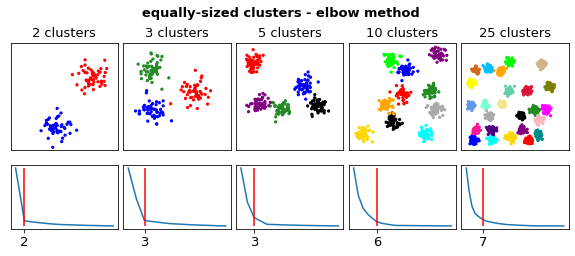

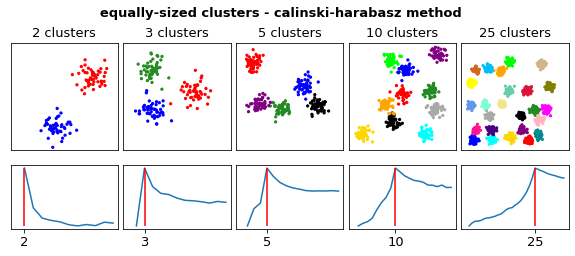

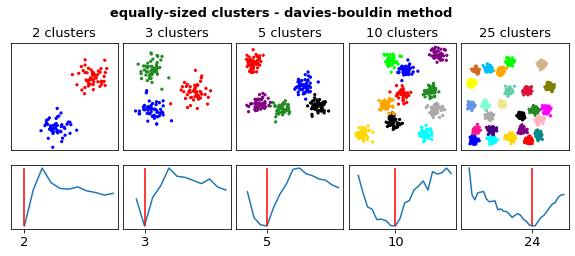

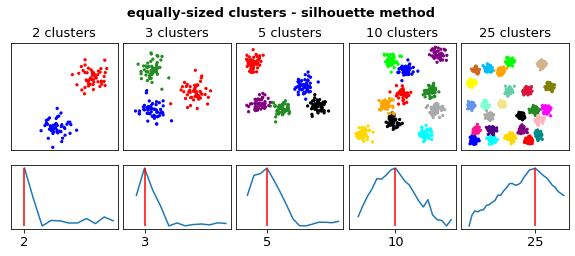

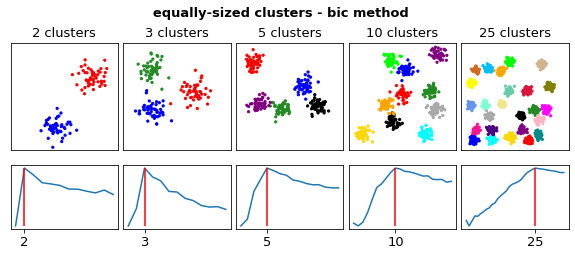

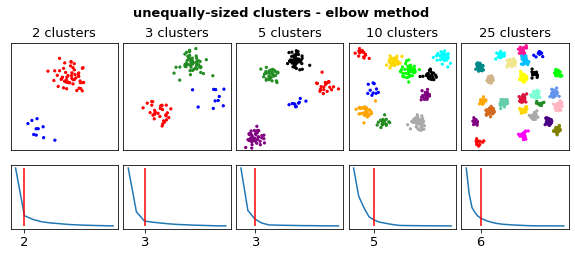

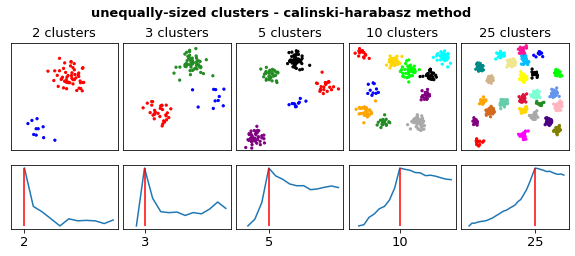

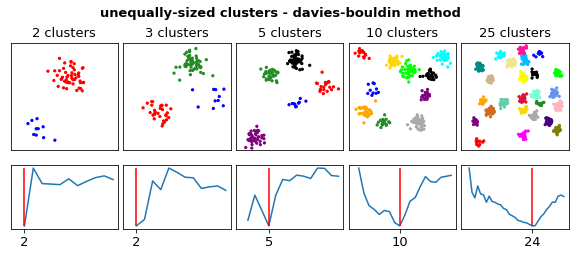

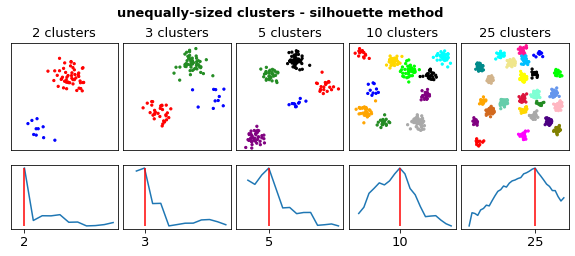

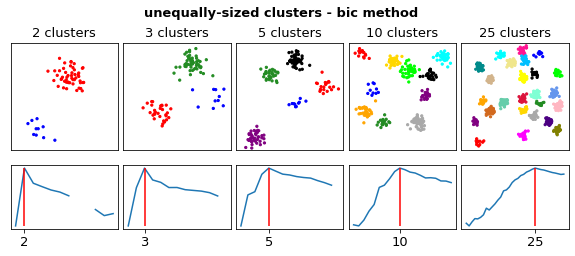

In [11]:
for indices, cluster_descr in zip([[0,1,2,3,4], [5,6,7,8,9]], ["equally-sized", "unequally-sized"]):
  
  for method in ["elbow", "calinski-harabasz", "davies-bouldin", "silhouette", "bic"]:
    
    fig, axs = plt.subplots(2, 5, figsize=(10, 3.6), gridspec_kw={'height_ratios':[2,1]})
    fig.suptitle(f"{cluster_descr} clusters - {method} method", fontsize=13, fontweight="bold")
    fig.subplots_adjust(wspace = .05, hspace=.05)
    
    for enum, i in enumerate(indices):
        
      min_k, max_k = summary.loc[i, ["min_k", "max_k"]]
        
      axs[0,enum].scatter(data[i]["X"][:,0], data[i]["X"][:,1], c=[COLORS[y] for y in data[i]["y"]], s=5)
      axs[0,enum].set_aspect("equal", "box")
      axs[0,enum].set_title(f"{len(set(data[i]['y']))} clusters", fontsize=13)
      axs[0,enum].set_xticks([])
      axs[0,enum].set_yticks([])
      axs[0,enum].set_xlim(-1.05, 1.05)
      axs[0,enum].set_ylim(-1.05, 1.05)
    
      axs[1,enum].plot(range(min_k, max_k + 1), scores[method][i])
      axs[1,enum].vlines(summary.loc[i, method], np.nanmin(scores[method][i]), np.nanmax(scores[method][i]), color="red")
      axs[1,enum].set_xlim(min_k - (max_k - min_k) * .05, max_k + (max_k - min_k) * .05)
      axs[1,enum].set_yticks([])
      axs[1,enum].set_xticks(sorted(set([summary.loc[i, method]])))
      axs[1,enum].tick_params(axis="both", which="major", labelsize=13)
    
    fig.savefig(f"{cluster_descr}-{method}.png", dpi=200, bbox_inches="tight")

# 2. Test methods sistematically

## 2.a Test methods

In [12]:
summary = pd.DataFrame(columns = ["ground-truth", "min-k", "max-k", "elbow", "calinski-harabasz", "davies-bouldin", "silhouette", "bic"])

for true_k in tqdm(range(1, 31)):
  scores = {"elbow": [], "calinski-harabasz": [], "davies-bouldin": [], "silhouette": [], "bic": []}

  centroids = extract_points(n=true_k, low=0, high=100, dimensions=5, min_distance=20)
    
  # each cluster will possibly have a different number of points
  n_obs_per_cluster = np.random.randint(30, 100, size=true_k)
  X = np.concatenate([
    np.random.multivariate_normal(mean=centroid, cov=np.diag([4**2]*5), size=n_obs_per_cluster[enum])
    for enum, centroid in enumerate(centroids)])
  
  min_k, max_k = 2, max(int(round(len(X) ** .5)), true_k * 2, 20)
  possible_k = range(min_k, max_k + 1)
    
  for k in possible_k:
    labels = kmeans_labels(X, n_clusters=k)
    
    scores["elbow"].append(inertia_score(X, labels))
    scores["calinski-harabasz"].append(calinski_harabasz_score(X, labels))
    scores["davies-bouldin"].append(davies_bouldin_score(X, labels))
    scores["silhouette"].append(silhouette_score(X, labels))
    scores["bic"].append(bic_score(X, labels))
    
  summary.loc[true_k, "ground-truth"] = true_k
  summary.loc[true_k, "min-k"] = min_k
  summary.loc[true_k, "max-k"] = max_k
  
  summary.loc[true_k, "elbow"] = KneeLocator(possible_k, scores["elbow"], curve='convex', direction='decreasing').knee  # elbow is better
  summary.loc[true_k, "calinski-harabasz"] = possible_k[np.nanargmax(scores["calinski-harabasz"])] # higher is better
  summary.loc[true_k, "davies-bouldin"] = possible_k[np.nanargmin(scores["davies-bouldin"])] # lower is better
  summary.loc[true_k, "silhouette"] = possible_k[np.nanargmax(scores["silhouette"])] # higher is better
  summary.loc[true_k, "bic"] = possible_k[np.nanargmax(scores["bic"])] # higher is better

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
  3%|▎         | 1/30 [00:00<00:24,  1.18it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ip

## 2.b Show results

In [13]:
metrics = ["elbow", "calinski-harabasz", "davies-bouldin", "silhouette", "bic"]

accuracy = pd.Series(summary[metrics].apply(lambda col: (col == summary["ground-truth"]).mean()), name="accuracy")
avg_distance = pd.Series(summary[metrics].apply(lambda col: (col - summary["ground-truth"]).abs().mean()), name="avg-distance")
performance = pd.concat([accuracy, avg_distance], axis=1).round(2).sort_values("avg-distance")

performance

,accuracy,avg-distance
calinski-harabasz,0.97,0.07
bic,0.97,0.07
silhouette,0.73,0.93
davies-bouldin,0.70,0.97
elbow,0.13,5.87


## 2.c Plot results

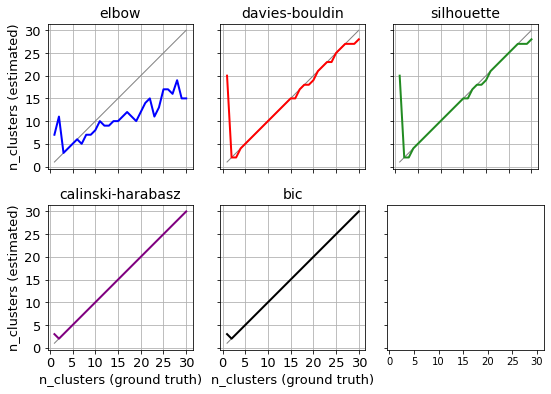

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace = .1, hspace=.25)

metrics_sorted = performance.sort_values("avg-distance", ascending=False).index

for enum, method in enumerate(metrics_sorted):
  axs[divmod(enum, 3)].set_title(method, fontsize=14)
  axs[divmod(enum, 3)].set_aspect("equal", "box")
  axs[divmod(enum, 3)].plot(summary.loc[:, "ground-truth"], summary.loc[:, "ground-truth"], lw=1, color="grey")
  axs[divmod(enum, 3)].plot(summary.loc[:, "ground-truth"], summary.loc[:, method], lw=2, color=COLORS[enum], label=method)
  axs[divmod(enum, 3)].tick_params(axis="both", which="major", labelsize=13)
  axs[divmod(enum, 3)].set_yticks(range(0, 31, 5))
  axs[divmod(enum, 3)].set_xticks(range(0, 31, 5))
  axs[divmod(enum, 3)].grid()

axs[1, 0].set_xlabel("n_clusters (ground truth)", fontsize=13)
axs[1, 1].set_xlabel("n_clusters (ground truth)", fontsize=13)
axs[0, 0].set_ylabel("n_clusters (estimated)", fontsize=13)
axs[1, 0].set_ylabel("n_clusters (estimated)", fontsize=13)

fig.savefig(f"systematic-comparison.png", dpi=200, bbox_inches="tight")